<h1 style="text-align:center;"> LSTM for Stock Market Prediction</h1>
<h2 style="text-align:center;"> Andvance Micro Deviced</h2>

<p style="font-size:18px;color:gray;"> <strong>Step 1:</strong> For this Predictive model we will utilize some modules that are necessary to obtain, create and visualize this predictive model such as <span class="py-modules">sqlalchemy</span>, <span class="py-modules">NumPy</span>, <span class="py-modules">Pandas</span>, <span class="py-modules">SciKitlearn</span>, <span class="py-modules">MatPlotLib</span>, and <span class="py-modules">Keras</span>.</p>

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime as dt
import requests
from sqlalchemy import create_engine
from config import password

<p style="font-size:18px;color:gray;"> <strong>Step 2:</strong> Now, we start building our model by first defining the dataset that the model will train on. We use the dataset provided by the National Stock Exchange of India: Tata Global Dataset, and read it using the ‘read_csv’ function by the Pandas library. To understand the structure of our dataset, we output the first 5 instances from the dataset using the head() method.</p>

In [2]:
# Connecting to Database
connection_string = f"ofygklqv:{password}@batyr.db.elephantsql.com:5432/ofygklqv"
engine = create_engine(f'postgresql://{connection_string}', pool_size=2, pool_recycle=1200, connect_args={'connect_timeout': 10},
client_encoding="utf8", pool_pre_ping=True)

In [3]:
ticker = "AMD"
df = pd.read_sql_query('select * from ticker', con=engine)
id = df[df['symbol']==ticker]['stock_id'].values[0] # returning ID for the specified ticker(symbol)
df = pd.read_sql_query(f'select * from stock WHERE stock_id = {id}', con=engine)
print(df.shape)
df["date"]=pd.to_datetime(df.date,format="%Y-%m-%d")
df.index = df['date']
df = df[["close"]]

(1258, 7)


#### Sort date and close
<p style="font-size:14px;color:gray;"> Since the dates and values are in descending order we need to reverse the dataframe</p>

In [4]:
df = df.iloc[::-1]
df

,close
date,
2016-07-06,5.040000
2016-07-07,5.020000
2016-07-08,5.100000
2016-07-11,5.010000
2016-07-12,5.140000
...,...
2021-06-28,87.080002
2021-06-29,89.519997
2021-06-30,93.930000


Text(0, 0.5, 'Close Price USD')

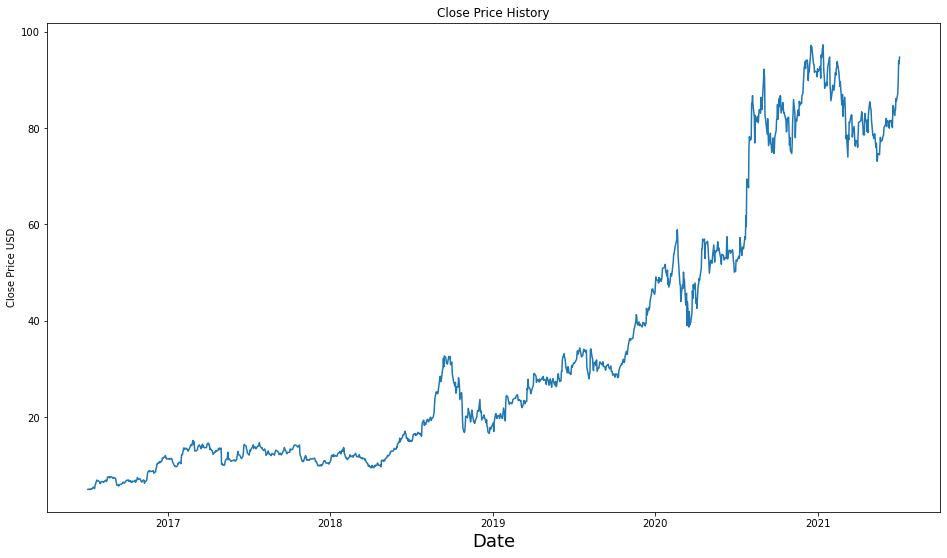

In [5]:
plt.figure(figsize=(16,9))
plt.title("Close Price History")
plt.plot(df['close'])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD")

In [6]:
# Create New DataFrame with close values
data = df
# Convert Dataframe to Numpy array
dataset = data.values

In [7]:
#Get number of row to train our module
training_data_len = math.ceil(len(dataset) * 0.80)
training_data_len

1007

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[3.25235614e-04],
       [1.08410148e-04],
       [9.75712012e-04],
       ...,
       [9.64006942e-01],
       [9.57285316e-01],
       [9.72354694e-01]])

In [9]:
# Create training Dataset
#create the scaled Training Data Set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=60:
    print(x_train)
    print(y_train)
    print()

[array([0.00032524, 0.00010841, 0.00097571, 0.        , 0.00140936,
       0.0008673 , 0.0017346 , 0.00140936, 0.00542064, 0.00433651,
       0.00433651, 0.00227666, 0.00899826, 0.01832176, 0.02135733,
       0.01994796, 0.01962272, 0.02005637, 0.01767129, 0.0135516 ,
       0.01398526, 0.01582827, 0.01734605, 0.01810494, 0.01723764,
       0.01604509, 0.01702081, 0.01864701, 0.02103209, 0.01918907,
       0.01810494, 0.0220078 , 0.02829575, 0.0278621 , 0.02883781,
       0.0262359 , 0.02666955, 0.02883781, 0.02797051, 0.02688638,
       0.02591067, 0.0253686 , 0.02710321, 0.02526019, 0.01983955,
       0.01322636, 0.00964874, 0.01008239, 0.00791413, 0.01116652,
       0.01094969, 0.01127493, 0.01246747, 0.01257589, 0.01387684,
       0.01474414, 0.01669558, 0.01420208, 0.01658716, 0.01712923])]
[0.01799652917965295]



In [10]:
# convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
samples,time_steps = x_train.shape
print(samples,time_steps)

947 60


In [12]:
# Reshaping the data
x_train = np.reshape((x_train),(samples,time_steps,1))
x_train.shape

(947, 60, 1)

In [13]:
# Building the LSTM Model
model = Sequential()
# Creating Layers
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
# Compiling the model
# Loss function is used to measure how well the model did on training.
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
#training the Model
# Batch size is the total number of training examples present in a single batch
# Epoch is the iterations when an entire dataset is passed forward and backward through a neural network
model.fit(x_train, y_train, batch_size=1, epochs=2,verbose=5)

Epoch 1/2
Epoch 2/2


In [16]:
# creating the Testing dataset 
# Array that contained scaled values test_data = scaled_data[training_data_len - 60:through the end, all columns]

test_data = scaled_data[training_data_len-60: , :]
# Creating testing datasets 
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])
  


In [17]:
# Converting data to a numpy Array
x_test = np.array(x_test)


In [18]:
# Reshaping the data, because LST model is expecting a 3 dimensional array
# x_test.shape[0] represents the number of Rows, 
#  x_test.shape[1] represents the number of time steps
# 3rd element in the dimensional array (1) represents the close price
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
# Get the models predicted price values
# This step "unscale" the values

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


Model Evaluation

In [20]:
# Evaluating our model, Getting the root mean error (RMSE), Model accuracy 
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.42286461757948673

Plotting the Data


In [21]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

<ipython-input-21-6a90206a058a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


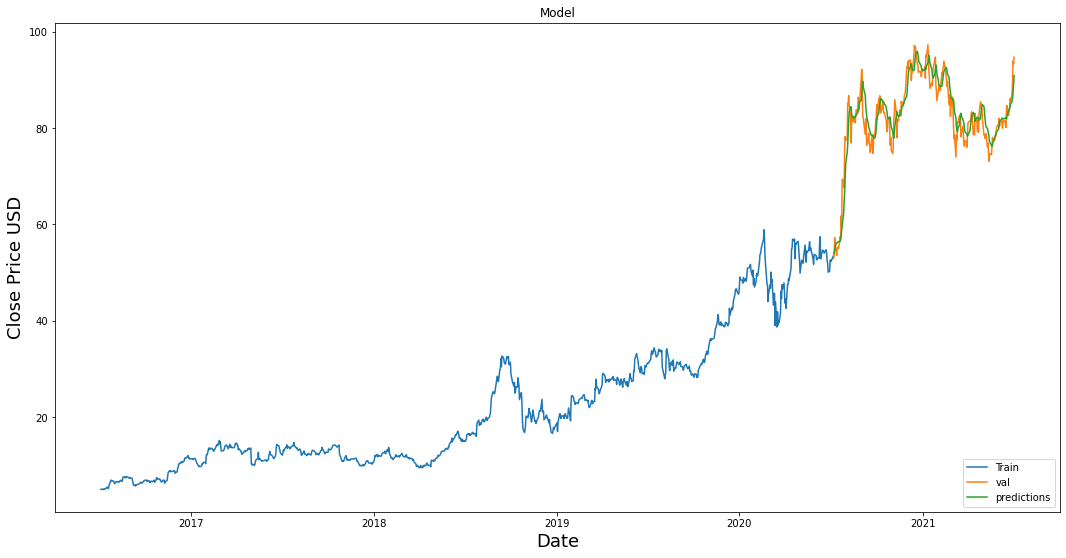

In [22]:
# Visualize the models data
plt.figure(figsize=(18,9))
plt.title('Model')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD", fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close','predictions']])
plt.legend(['Train','val','predictions'], loc='lower right')
plt.show()

In [23]:
# show the Valid(actual prices) and the predicted prices
valid

,close,predictions
date,,
2020-07-07,52.930000,53.945702
2020-07-08,53.430000,54.195648
2020-07-09,57.259998,54.458080
2020-07-10,55.880001,55.440674
2020-07-13,53.590000,56.191284
...,...,...
2021-06-28,87.080002,85.485985
2021-06-29,89.519997,86.178001
2021-06-30,93.930000,87.289680


In [24]:
# Saving Model
model.save("advmicrodevice_model.h5")